# Predicting Bacteria Growth and Patterns

The goal is to calculate the doubling time of the E. Coli bacteria. The doubling time is the time it takes for a bacteria culture to double its size.

The early growth phase of a bacterial culture can be stated mathematically as:

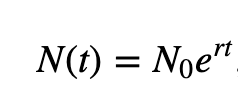

where  N(t)  is the number of cells at time  t ,  N0  is the initial number of cells and  r  is the growth rate in dimensions of time.

We will use a a series of images E. coli cells growing on a hard agar subtstrate at 100x magnification taken at 5 minutes intervals.


Let's start by importing the necessary libraries

In [10]:
import glob # For parsing directories and files
import skimage.io # For basic image processing
import matplotlib.pyplot as plt # For plotting
import numpy as np
from scipy import ndimage
import pathlib
import imageio as imageio

The uncompressed file contains images coming from 2 different capturing techniques, capturing the fluorescence of different proteins. 

We will use the TRITC files.

In [12]:
#Load the TRITC files using glob into a variable
files = [x for x in pathlib.Path('2016-04-03-muir_dryrun').glob('*/*TRITC_*.tif')]




Files are not sorted, so let's do it:

In [17]:
#Sort images
files = sorted(files)
len(files)

30

We have 30 images, let's see them all in a 6x5 grid of 30x24 size

C:\Users\akash\AppData\Local\Temp\ipykernel_19268\2167132118.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  axes[i//5,i%5].imshow(imageio.imread(str(image)), cmap='gray')


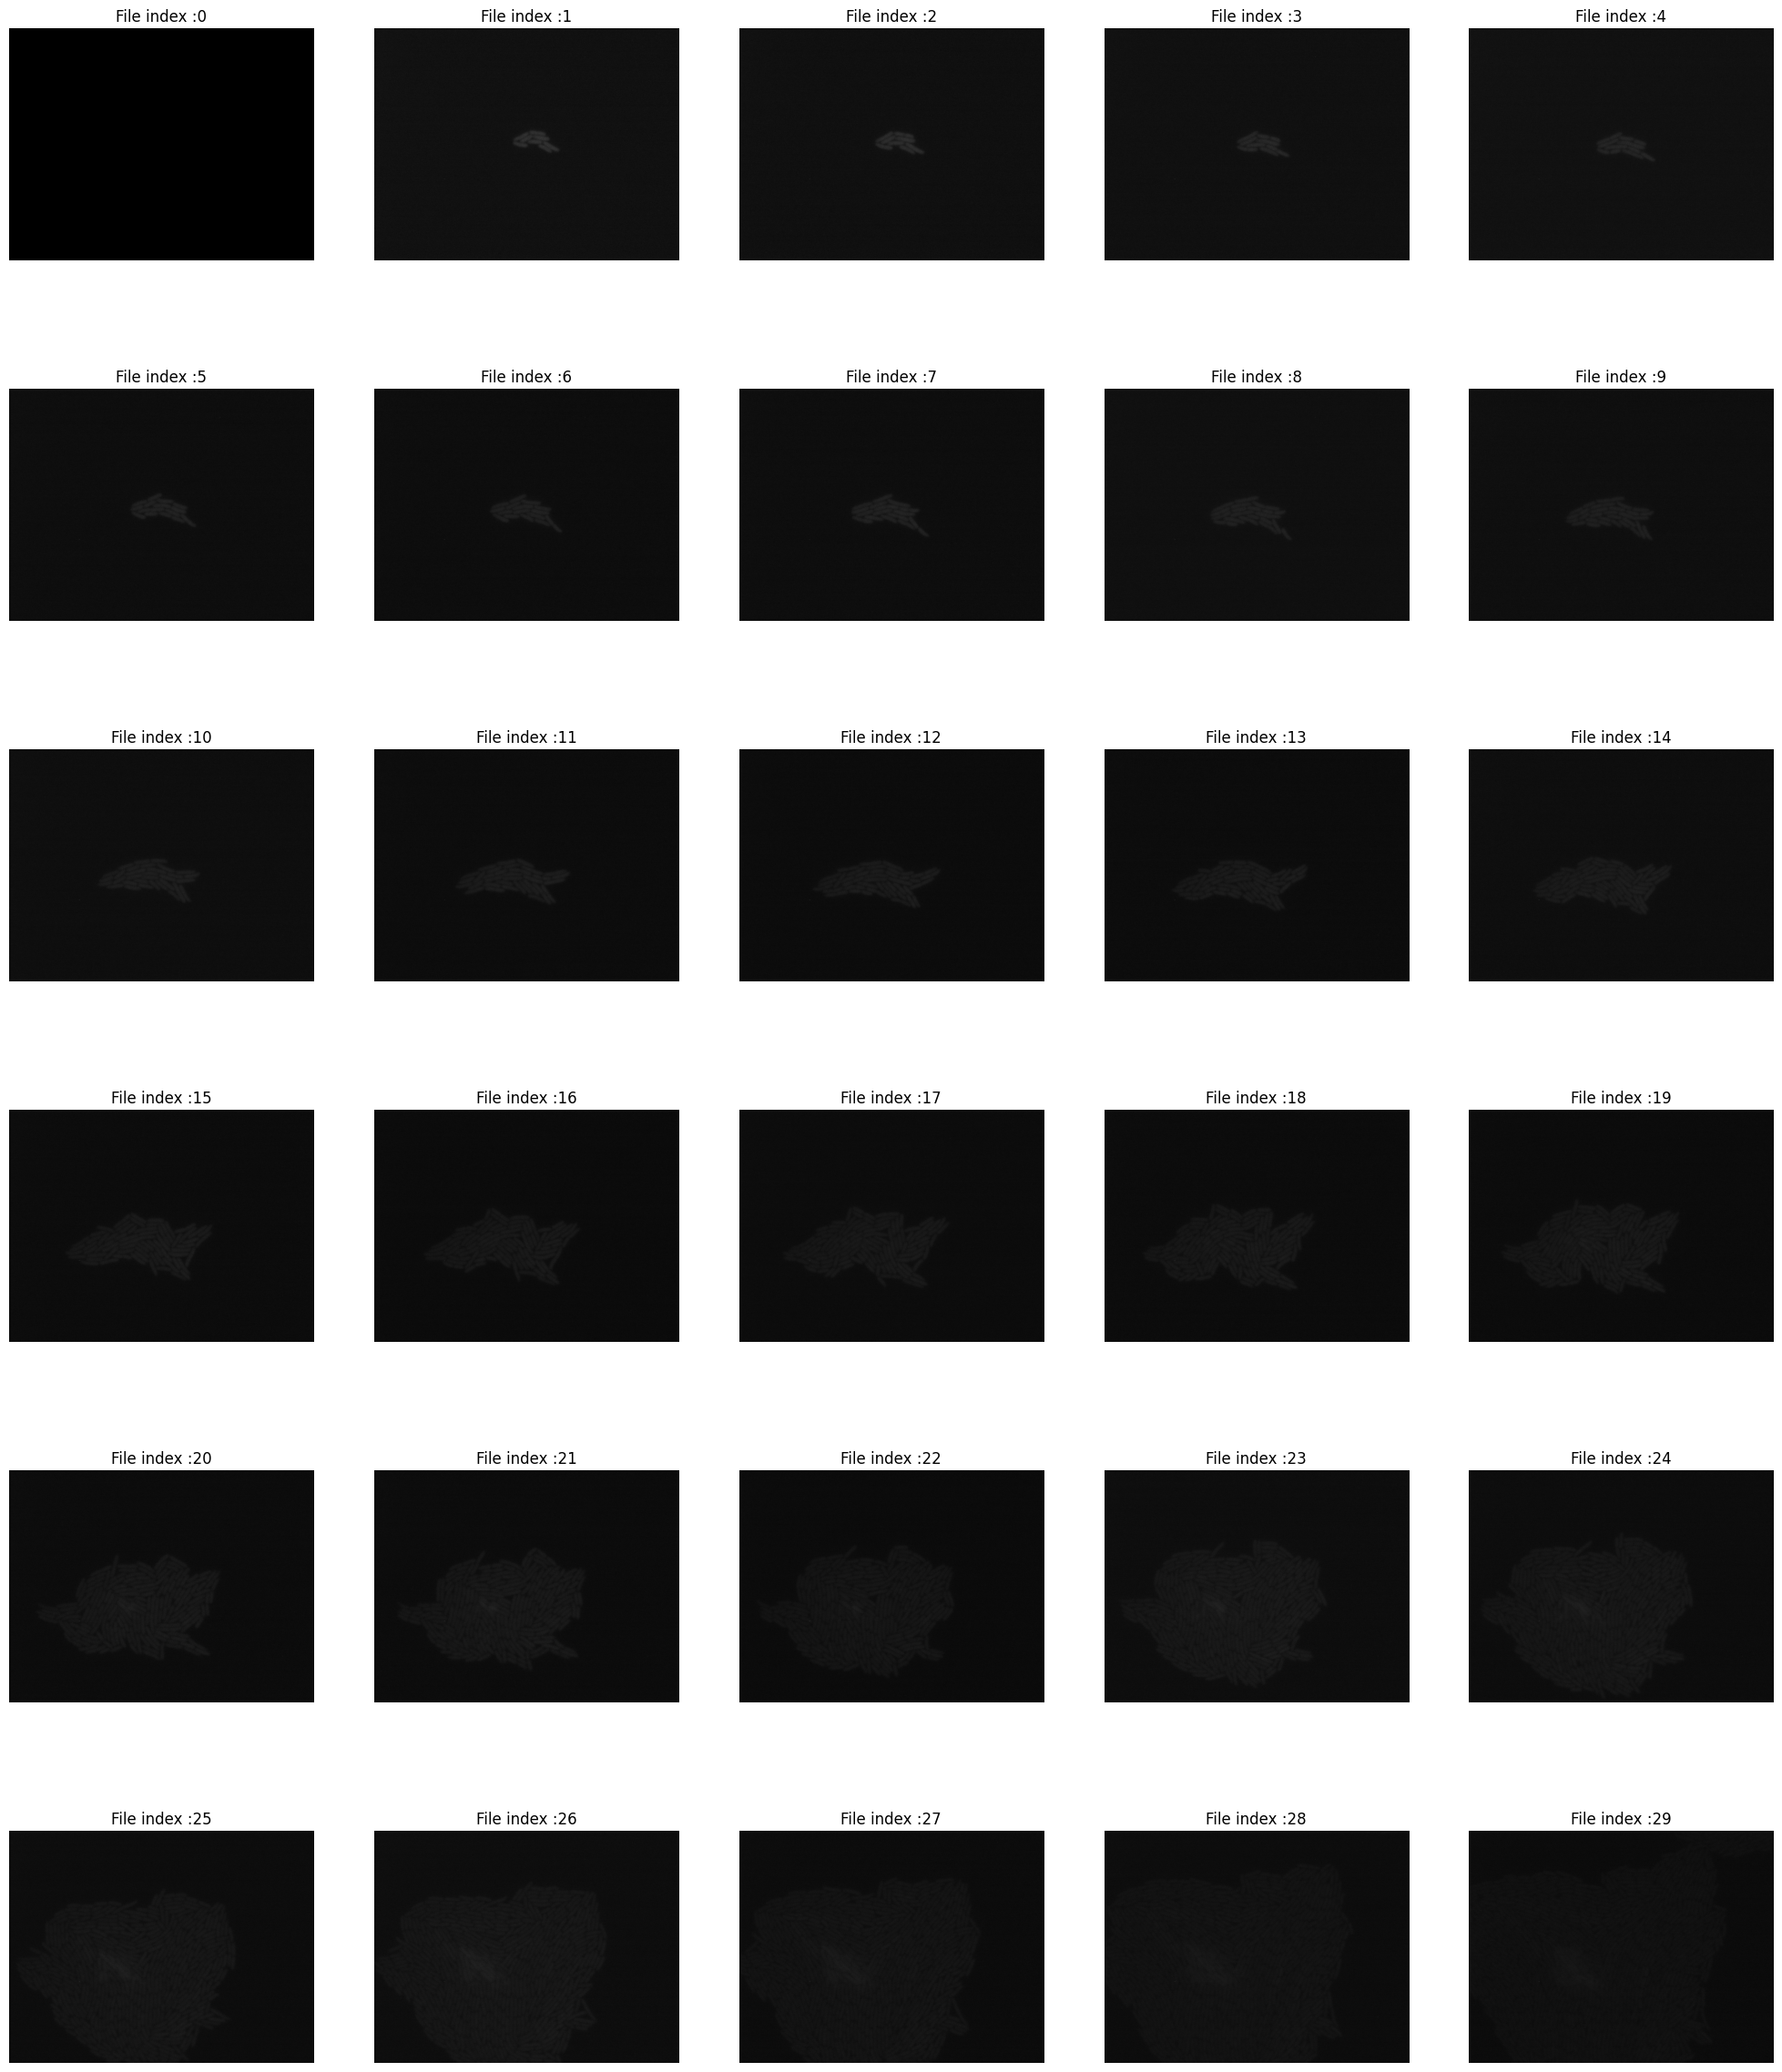

In [14]:
#Visualize Images
fig, axes = plt.subplots(6,5, figsize=(25,30))

for i, obj_indices in enumerate(files):
    image = files[i]
    axes[i//5,i%5].imshow(imageio.imread(str(image)), cmap='gray')
    axes[i//5,i%5].axis('off')
    axes[i//5,i%5].set_title('File index :' + str(i))






The result is not too good... we can only see a faint shadow in some of the images.

Let's have a closer look at image with index 15:

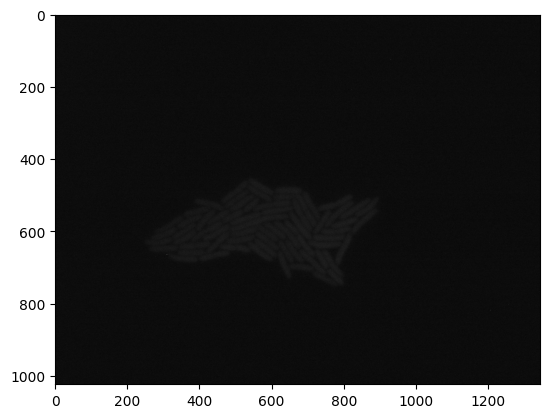

In [18]:
#Read image 15
im = skimage.io.imread(files[15])
plt.imshow(im, cmap='gray')

Let's zoom to see only the center of the image, rows 550 to 650 and columns 400 to 500

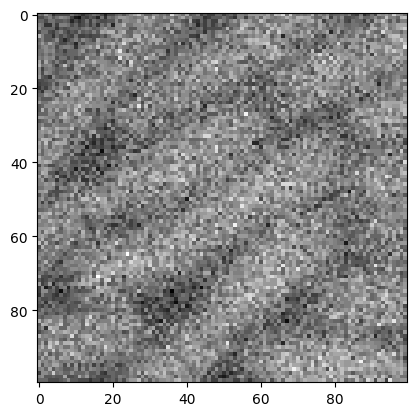

In [19]:
#Zoom in
im = skimage.io.imread(files[15])[550:650, 400:500]
plt.imshow(im, cmap='gray')



And the top left 100x100 pixels

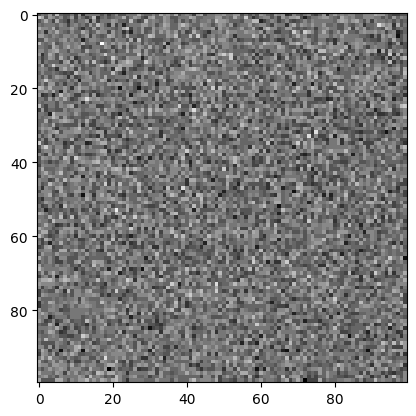

In [20]:
#Zoom In
im = skimage.io.imread(files[15])[:100, :100]
plt.imshow(im, cmap='gray')



The image quality is pretty bad.



## Let's try to improve the quality of the image
Let's apply the following 4x4 filter:

It is a blur filter, it will help removing noice, averaging the pixels and making the changes smoother.

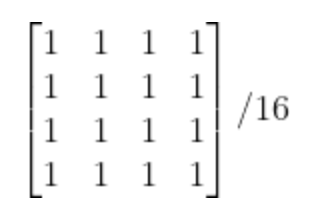

------------------------------------

Let's apply the filter specified above using ndimage.convolve

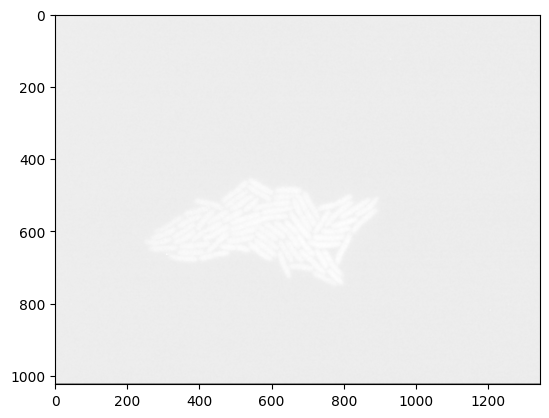

In [23]:
#Read image 15
image = skimage.io.imread(files[15])

#Create Kernel for filtering the image
kernel = np.ones([4,4])/16            

#Convolve the image
filtered = ndimage.convolve(image, kernel, mode='constant', cval=0.0)

#Show new image
plt.imshow(filtered, cmap='gray')




And repeat the zooms

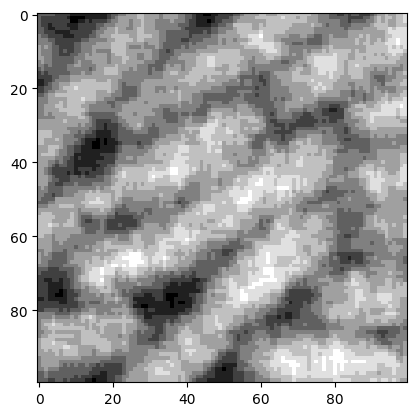

In [24]:
#Zoom in
im = filtered[550:650, 400:500]
plt.imshow(im, cmap='gray')


To fullly separate the pixels from the bacteria from the background let's convert the image into a binary image and for that we need to find the thershold.

To do that let's plot the histogram of the image so we can identify hot to isolate the pixels with relevant informations (use skimage.exposure.histogram).

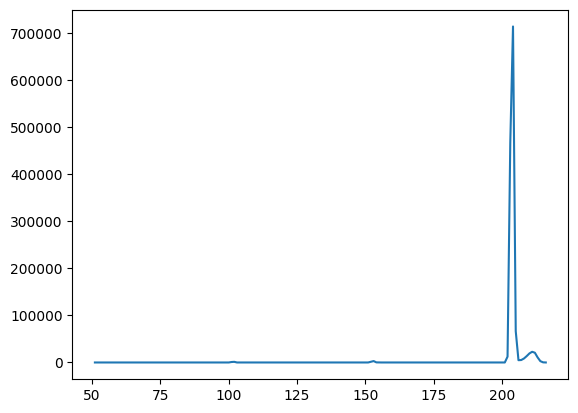

In [28]:
from skimage.exposure import histogram

#mMake histogram
hist, hist_centers = histogram(filtered)

# Plotting segmentation
fig, ax = plt.subplots()

ax.plot(hist_centers, hist)

plt.show()

There is a very tall peak that makes it difficult to read the lower values of the chart. To improve the chart understanding let's display it in logarithmic scale

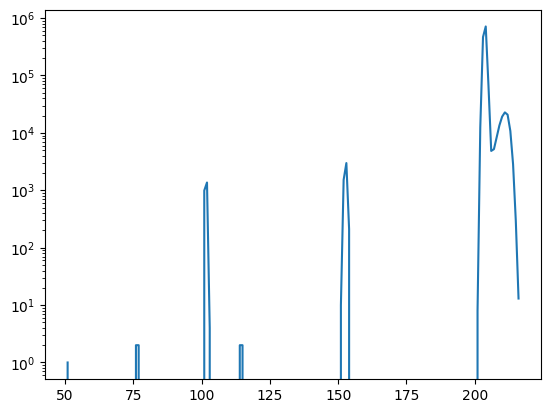

In [29]:
from skimage.exposure import histogram

hist, hist_centers = histogram(filtered)

fig, ax = plt.subplots()

ax.plot(hist_centers, hist)
ax.set_yscale('log')

plt.show()

It looks like all information is in the last bins of the histogram. Let's visualize only the last 20 bins

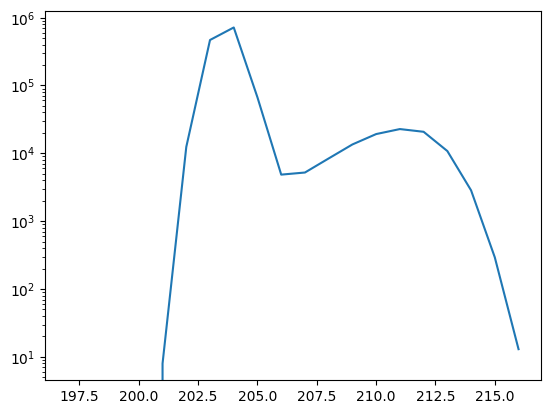

In [30]:
from skimage.exposure import histogram

hist, hist_centers = histogram(filtered)

# Plotting segmentation
fig, ax = plt.subplots()

ax.plot(hist_centers[-20:], hist[-20:])
ax.set_yscale('log')


plt.show()




In this histogram we can see 2 peaks, one of them corresponds to the background noise (the higher peak) and the other are the pixels corresponding to the bacteria. We will use a threshold value of 205. Let´s create a binary image (from the filtered image).

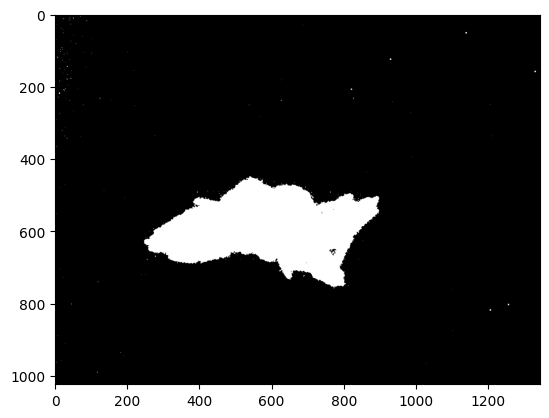

In [41]:

binary_im = (filtered > 205)
plt.imshow(binary_im, cmap = 'gray')


Now let's create a function that transforms the images. The function should accept an image and should perform the convolution (filter) and create the binary image from it (with the threshold we have found before). The function will return the binary image.

In [42]:
#Return binary image
def img_prepare(im):
    kernel = np.ones([4,4])/16
    f_im = ndimage.convolve(im, kernel, mode='constant', cval=0.0)
    binary_im = (f_im > 206)*1
    return binary_im


Let´s test on another image

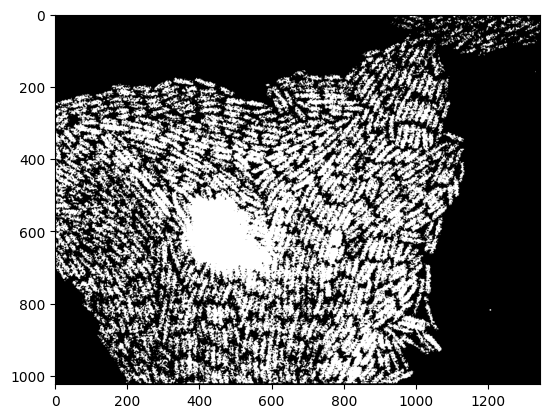

In [44]:
#Test on image 29
im = skimage.io.imread(files[29])
im_prep = img_prepare(im)

plt.imshow(im_prep, cmap = 'gray')

Using this function let's display all images with the same grid we used before

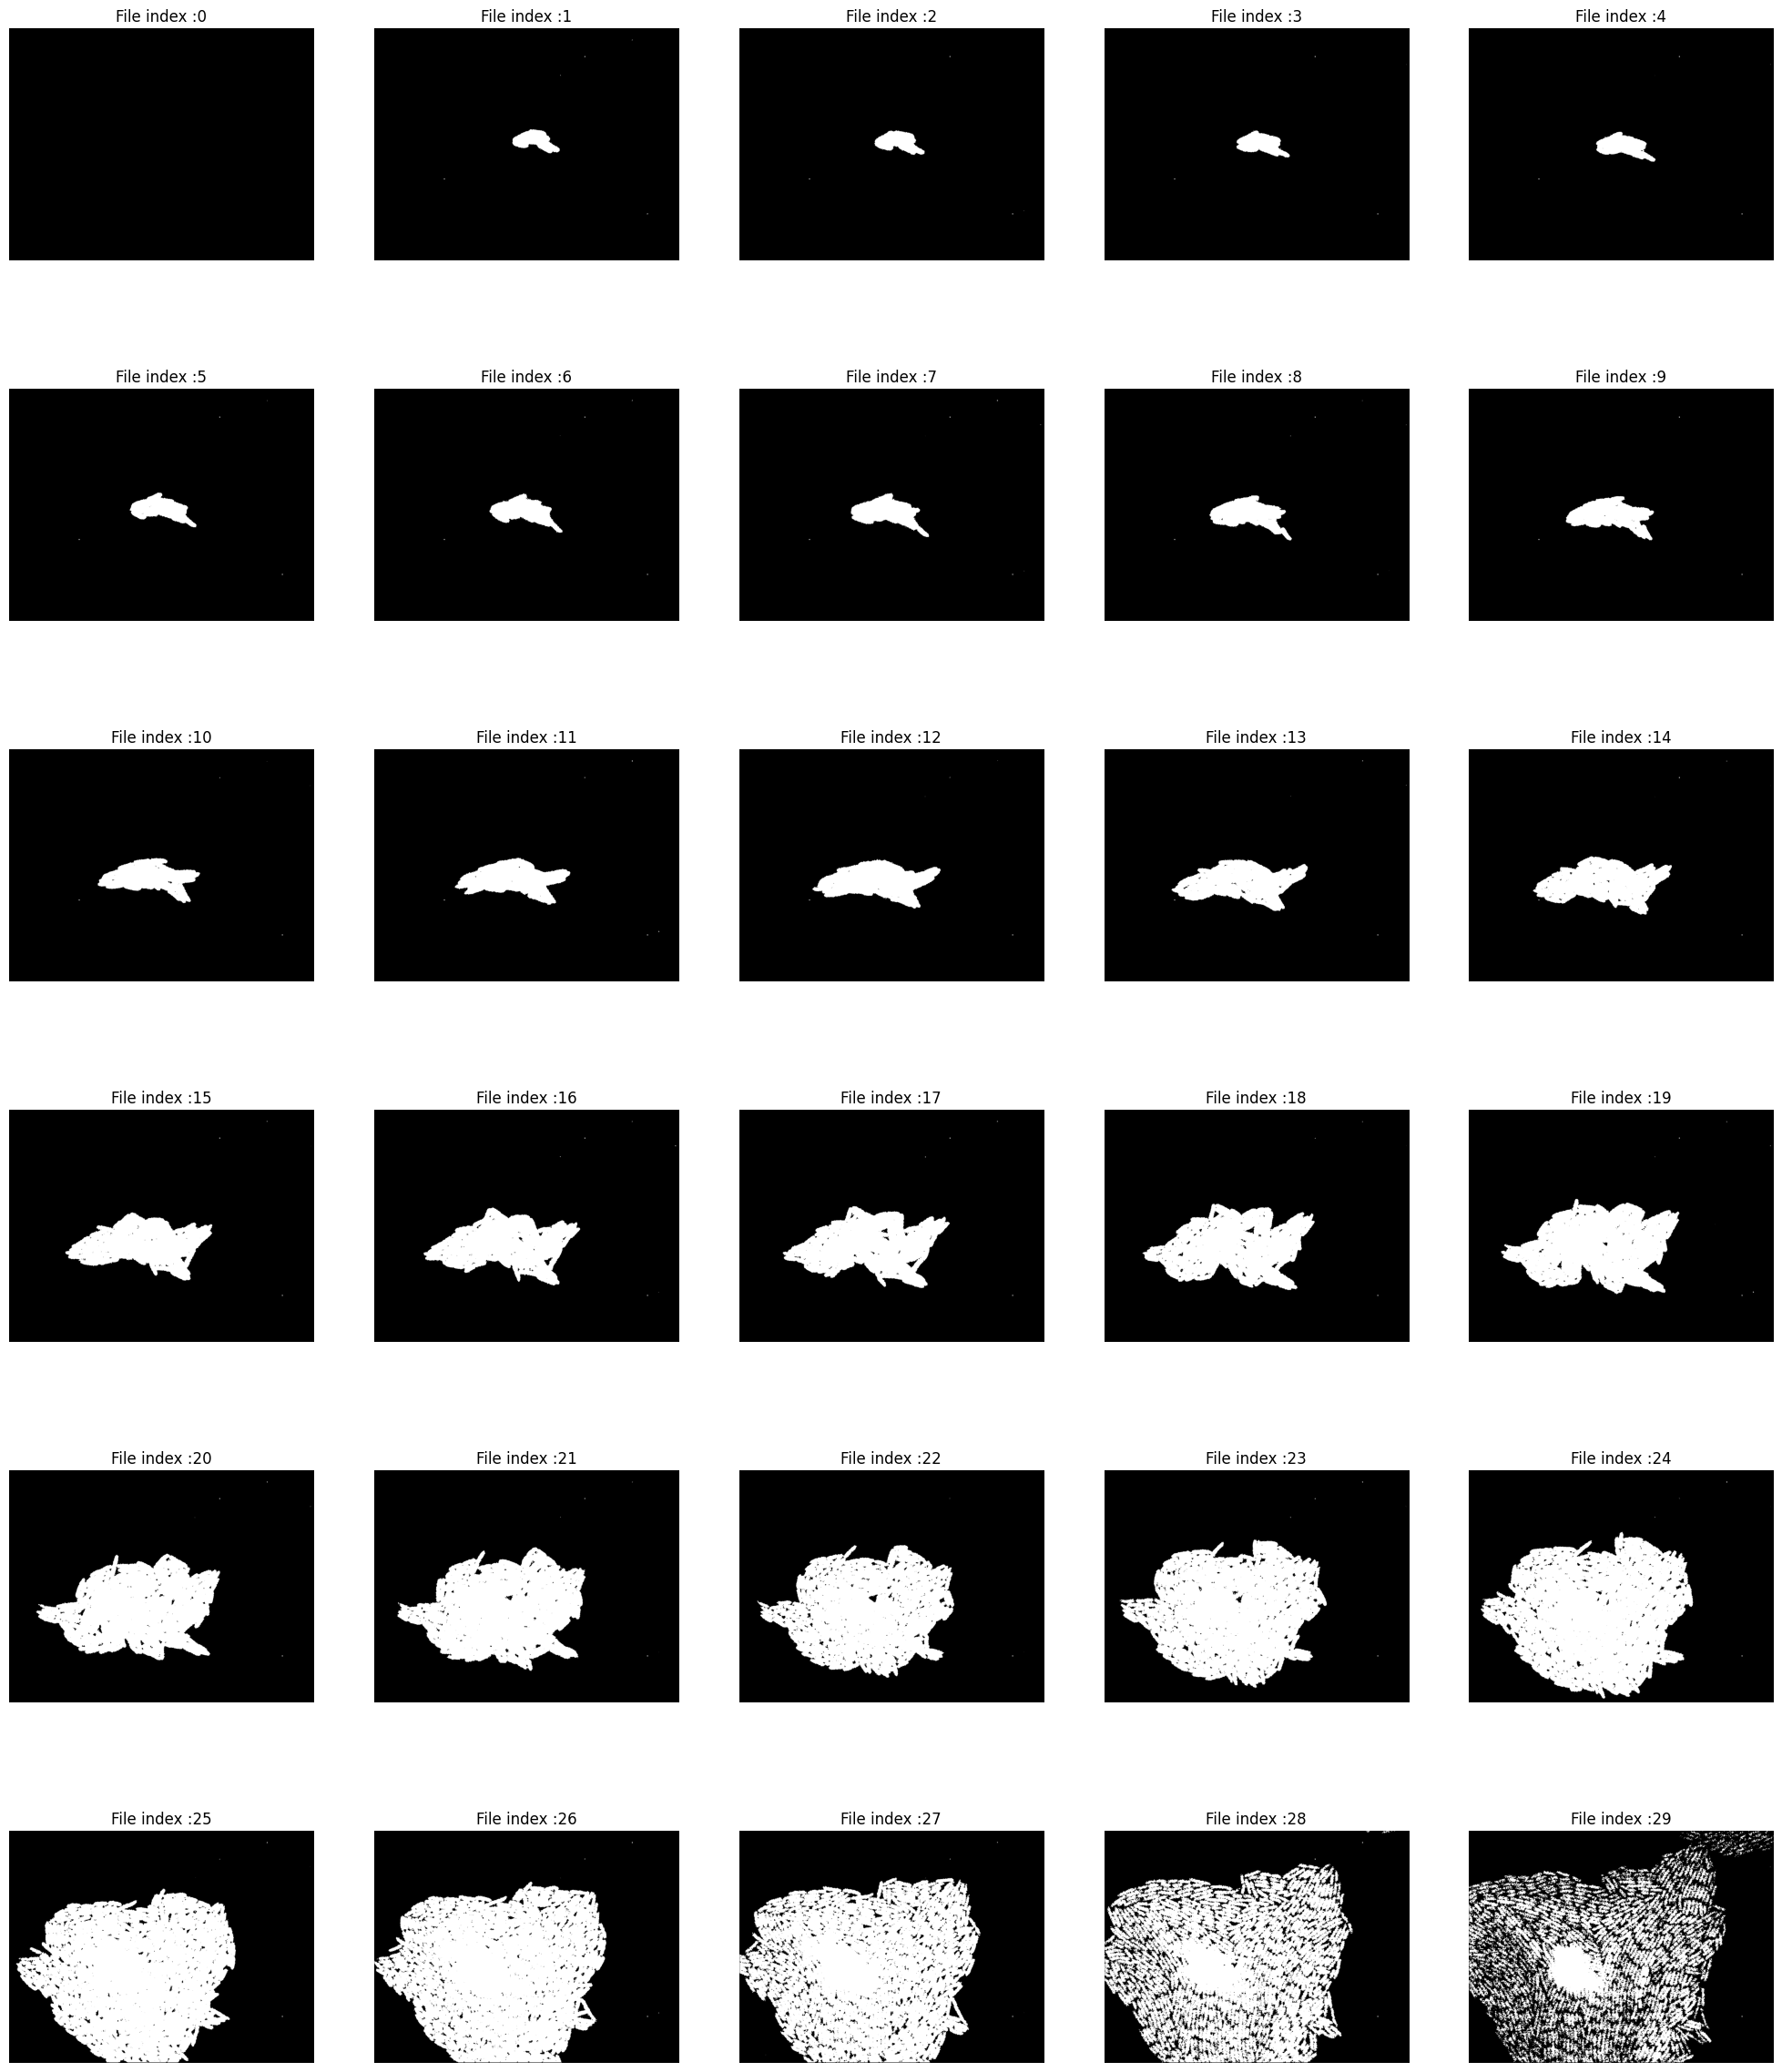

In [45]:
#Apply function to all images
fig, axes = plt.subplots(6,5, figsize=(25,30))

for i, obj_indices in enumerate(files):
    im = files[i]
    im = skimage.io.imread(im)
    im_prep = img_prepare(im)
    axes[i//5,i%5].imshow((im_prep), cmap='gray')
    axes[i//5,i%5].axis('off')
    axes[i//5,i%5].set_title('File index :' + str(i))






As we said at the beginning we are interested in calculating the doubling time, what is related to the growth rate. This means we are interested in knowing the size of the population in every image. This could be achieved counting the number of bacteria. This is not possible as with the images we have we can't efectively separate them in the image. Another method (considering we can assume they are all the same size) is to calculate the surface the bacteria population occupies. We can do this by just counting the active pixels in the binary image.

Let´s create a function that accepts a binary image and returns the area in pixels of the bacteria

In [46]:
#Calculate area
def bacteria_area(bin_im):
    return bin_im.sum()

Let´s test with a single image

In [48]:
#Test with image 10
im = skimage.io.imread(files[10])
im_prep = img_prepare(im)
print('The area in pixels of bacteria population in image 10 is: {}'.format(bacteria_area(im_prep)))

The area in pixels of bacteria population in image 10 is: 46047


Now let's calculate the ara for all images. 

In [49]:
#Set area to 0
bact_area = np.zeros(len(files))

#Apply function
for i, obj_indices in enumerate(files):
    im = skimage.io.imread(files[i])
    im_prep = img_prepare(im)
    area = bacteria_area(im_prep)
    bact_area[i] = area




In [50]:
#Print areas
print(bact_area)

[     0.  12301.  14110.  15656.  18142.  21702.  25477.  29989.  34149.
  39442.  46047.  54889.  65098.  75270.  87020. 103761. 122149. 143421.
 167412. 199610. 230966. 272729. 312182. 368549. 433751. 504929. 570307.
 615519. 608579. 462243.]


Let's display these values in a chart. In the x axis we have the time (these images were taken with 5 minutes difference) and the area in pixels in the y axis.

Text(0, 0.5, 'cell area [pixels]')

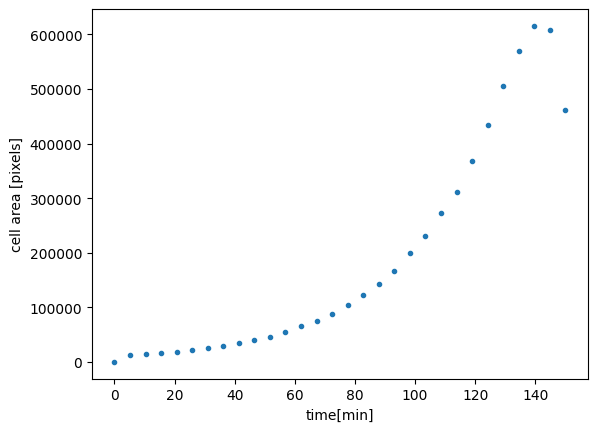

In [52]:
#Plot growth
fig, ax = plt.subplots()

x = np.linspace(0, 30*5,  num=30)

ax.scatter(x, bact_area, s=9)
ax.set_xlabel('time[min]')
ax.set_ylabel('cell area [pixels]')






We are observing the exponential growth we were expecting!! There seems to be an issue with the last 3 images and also the first one is not useful for our goal as it is empty. Let's discard them! 

Let's create another array excluding the last 3 images (outliers) and the first one.

In [53]:
#Discarding not useful images
bact_area_wo = bact_area[1:-3]


Text(0, 0.5, 'cell area [pixels]')

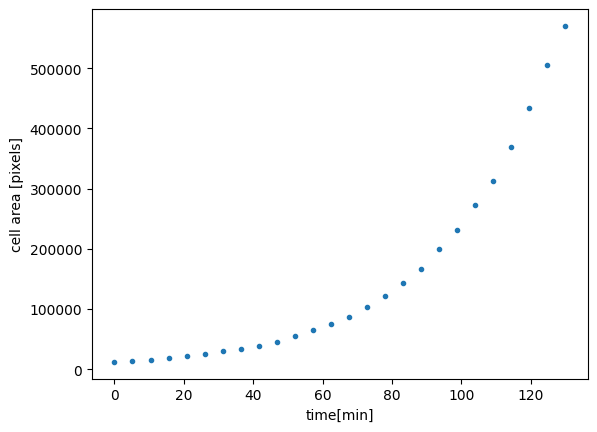

In [54]:
#Plot growth again
fig, ax = plt.subplots()

x = np.linspace(0, 26*5,  num=26)

ax.scatter(x, bact_area_wo, s=9)
ax.set_xlabel('time[min]')
ax.set_ylabel('cell area [pixels]')





Now that we have the empirical growth every five minutes we need to find the doubling time. To do this we need to do several things.

First find a value of r in the formula we saw at the beginning that adjusts this data best.

This is the formula as a reminder:

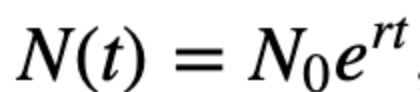

N0 is the size (in our case size in pixels) of the population at the beginning (bact_area_wo[0]).


Finding this optimum r in data with an exponential behaviour is the job of a logistic regression. But this time we will do it with our own code.

We first need a formula to calculate the error involved for a particular value of r. We will use this one:

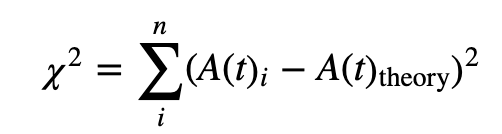

This is often called the Chi-squared statistic. n  is the number of data points and A(t)theory is the expected cellular area at time t, given by our model of exponential growth (the abouve formula) for a given value of r. A(t) is the data we have obtained from the images. We will try for 200 values of r between 0 and 0.1. For each of the values of r we will calculate the theoretical value of the area at each time an image has been taken, and apply the chi error formula. We store the chi errors for the 200 values of r and we will use the value of r with the lowest index. 

1.- let´s create an r_range numpy array with 200 values between 0 and 0.1 

In [55]:
#Create range
r_range = np.linspace(0, .1, 200)

2.- Let´s create a numpy array initialized with 0, with the same size as the above r_range where we will store the error for each value of r.

In [57]:
#Create chi_sq with 0s
chi_sq = np.zeros(200)

3.- Let´s loop through the values of r in r_range and for each value of r do_
    - We will calculate the theoretical value of the area (theo) using the N(t) formula. 
    - We will calculate and store the chi squared error for that value of r

In [59]:
#Create a time range
time_range = np.arange(0, len(bact_area_wo)) * 5 

# Iterate through each possible growth rate. 
for i in range(len(r_range)):
    # Compute the theoretical value at each time point. 
    theo = bact_area_wo[0] * np.exp(r_range[i] * time_range)

    # Compute the sum squared residuals. 
    chi_sq[i] = np.sum((bact_area_wo - theo)**2)
    
    
chi_sq

array([1.17804512e+12, 1.17337481e+12, 1.16845996e+12, 1.16328783e+12,
       1.15784509e+12, 1.15211774e+12, 1.14609115e+12, 1.13975001e+12,
       1.13307828e+12, 1.12605925e+12, 1.11867543e+12, 1.11090862e+12,
       1.10273982e+12, 1.09414928e+12, 1.08511645e+12, 1.07562002e+12,
       1.06563789e+12, 1.05514719e+12, 1.04412428e+12, 1.03254481e+12,
       1.02038374e+12, 1.00761537e+12, 9.94213403e+11, 9.80151044e+11,
       9.65401071e+11, 9.49935955e+11, 9.33727998e+11, 9.16749497e+11,
       8.98972941e+11, 8.80371240e+11, 8.60918002e+11, 8.40587851e+11,
       8.19356799e+11, 7.97202679e+11, 7.74105653e+11, 7.50048789e+11,
       7.25018737e+11, 6.99006498e+11, 6.72008321e+11, 6.44026718e+11,
       6.15071639e+11, 5.85161808e+11, 5.54326259e+11, 5.22606084e+11,
       4.90056427e+11, 4.56748758e+11, 4.22773467e+11, 3.88242808e+11,
       3.53294251e+11, 3.18094290e+11, 2.82842772e+11, 2.47777801e+11,
       2.13181314e+11, 1.79385394e+11, 1.46779434e+11, 1.15818247e+11,
      

Let's plot now the error for each value of r

Text(0, 0.5, 'X²')

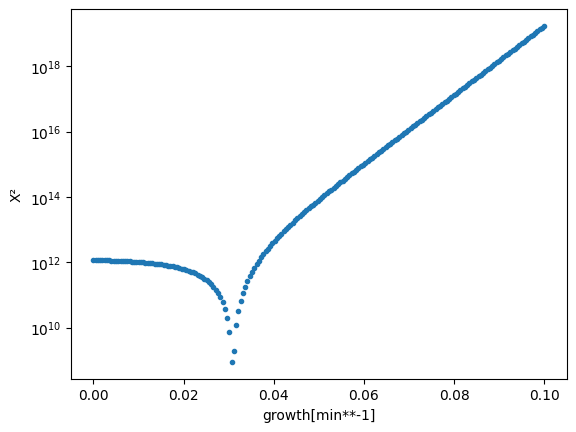

In [60]:
# Plot the chisq statistic
fig, ax = plt.subplots()


ax.scatter(r_range, chi_sq, s=9)
ax.set_xlabel('growth[min**-1]')
ax.set_yscale('log')
ax.set_ylabel('X²')




We can easily see there is a clear minimum (a value of r with the lowest error). Let's identify this value, finding the index with the minimum value (np.argmin) and then getting the value at this index.

In [61]:
# Find the minimum of the chi_sq. 
minimum = r_range[np.argmin(chi_sq, axis=-1)]
minimum





0.030653266331658293

Let's display in a chart the formula with the calculated value of r and the area obtained from the images.

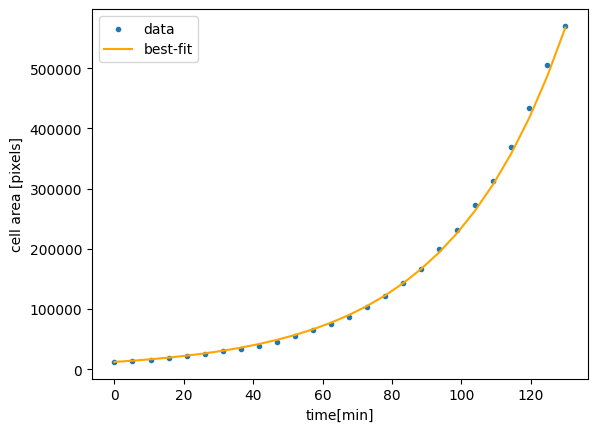

In [62]:
# Compute the best fit

best_fit = bact_area_wo[0] * np.exp(minimum * time_range) 

fig, ax = plt.subplots()

x = np.linspace(0, 26*5,  num=26)

ax.scatter(x, bact_area_wo, s=9)
ax.plot(x, best_fit, color = "orange")
ax.set_xlabel('time[min]')
ax.set_ylabel('cell area [pixels]')
plt.legend(["data", "best-fit"])



We have a great fit!! now we just need to find the doubling time.

We just need to apply the formula:

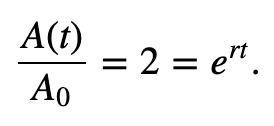

and isolate t. 

So te will be the result of this:

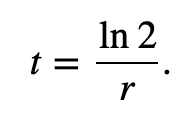

Let's calculate it. 

In [65]:
#Calculate doubling time
t = np.log(2)/minimum
t

22.61250638220149

# Conclusion

Based on the images of E. Coli bacteria growth, it has been determined that the doubling time of the bacteria is 22.61 minutes. This means that every 22.61 minutes, the bacterial culture doubles in size. Understanding the doubling time is important for researchers and scientists who study bacteria, as it helps them to predict how quickly a bacterial population will grow and respond to different environmental conditions. With this knowledge, they can develop strategies to control bacterial growth and prevent the spread of harmful bacteria. Overall, the determination of the doubling time of the E. Coli bacteria is an important contribution to the field of microbiology.